In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from spectral_cube import SpectralCube
import astropy.units as u
from astropy.utils import data
import os
from reproject import reproject_interp
#from math import e
#import sys
#import time

To do:
speed up Qrot -> Imad 
    make two different Ntot functions? Okay, but not any faster

make installable -> follow ArtPop format
slider with contour levels? sorta working


In [24]:
def Qrot(T):
    '''
    The rotational partition function, which will be called in the column density function
    
    Parameters
    ----------
    T: float
        the excitation temperatures
    
    Returns
    -------
    zeta: float
        the rotational partition function evaluated at the input excitation temperature
    '''
    zeta=0.0
    leng = 100000
    ar = np.arange(leng)
    
    for j in range (0,leng):
        f1 = 2*j +1
        Ej = j*(j+1)*h*B
        f2 = np.exp(-Ej/(k*T))
        zeta = zeta + (f1*f2)
        
    return zeta

def Ntot(freq, Tex, Aul, gup, Elow, area): 
    '''
    Column Density in Optically Thin Regime
    
    Parameters
    ----------
    freq: float
        the frequency of your transition
    Tex: float
        the excitation temperature
    Aul: float
        Einstein coefficient
    gup: float
        the statistical weight (or degeneracy) of the upper state of the given transition
    Elow: float
        the energy of the lower state of the given transition
    area: float
        the channel width * intensity at the given pixel
    
    Retruns
    -------
    Ntot*1e5: float
        Column Density in cm^2
    '''
    #s= time.time()
    #print(f'Starting F1 at {s}')
    
    #f1 = 8.*np.pi*freq**3/(Aul*gup*c**3)
    #f2 = (h*freq)/k
    #f3 = 1./((1./(np.exp(f2/Tex)-1))-(1./(np.exp(f2/Tbkg))))
    #f4 = 1.-np.exp(-f2/Tex)
    #f5 = np.exp(Elow/Tex)
    
    #s5 = time.time() - s 
    #const = (f1/f2)*f3*f5*area/f4 #Qrot(Tex)
    #print(f'all steps before Qrot {s5}')

    #Ntot = (f1/f2)*f3*f5*Qrot(Tex)*area/f4
    
    #s6 = time.time() - s5
    #print(f'Qrot took {s6}')

    f1 = 8.*np.pi*freq**3/(Aul*gup*c**3)
    f2 = (h*freq)/k
    f3 = 1./((1./(np.exp(f2/Tex)-1))-(1./(np.exp(f2/Tbkg))))
    f4 = 1.-np.exp(-f2/Tex)
    f5 = np.exp(Elow/Tex)
    Ntot = (f1/f2)*f3*f5*Qrot(Tex)*area/f4
        
    return Ntot*1e5

def Ntot_t(freq, Tex, Aul, gup, Elow,tau):
    '''
    Column Density in non-Optically Thin Regime
    
    Parameters
    ----------
    freq: float
        the frequency of your transition
    Tex: float
        the excitation temperature
    Aul: float
        the Einstein coefficient
    gup: float
        the statistical weight (or degeneracy) of the upper state of the given transition
    Elow: float
        the energy of the lower state of the given transition
    tau: float
        the optical depth
    
    Retruns
    -------
    Ntot*1e5: float
        Column Density in cm^2
    '''
    f1 = 8.*np.pi*freq**3/(Aul*gup*c**3)
    f2 = (h*freq)/k
    f4 = 1.-np.exp(-f2/Tex)
    f5 = np.exp(Elow/Tex)
    Ntot = f1*f5*Qrot(Tex)*tau/f4

    return Ntot*1e5
    
def tau(freq,Tex,Tmb):
    '''
    The optical depth
    
    Parameters
    ----------
    freq: float
        the frequency of the given transition
    Tex: float
        the excitation temperature of a given element in the dataset
    Tmb: float
        the main beam brightness temperature
    
    Returns
    -------
    -np.log(f4): float
        the optical line depth for an element of the dataset, given the input parameters 
    
    '''
    f1 = Tmb*1.38e-23/(freq*6.62e-34)
    f2 = (6.62e-34*freq)/1.38e-23
    f3 = 1./((1./(np.exp(f2/Tex)-1))-(1./(np.exp(f2/2.73))))
    f4 = 1.+(f1*f3)
    return -np.log(f4) 

def RMS_Map(cube, chan_low, chan_high):
    '''
    Generating the RMS Map from a subcube of channels that have no signal 
    
    Parameters
    ----------
    cube: 3D array-like 
        fits data 
    chan_low: int
        the lowest channel without signal you want for your RMS calculation
    chan_high: int
        the highest channel without signal you want for your RMS calculation
    
    Returns
    -------
    RMS: array-like
        the RMS data for each pixel 
    
    '''
    Dsquare = np.square(cube[0].data)
    P1 = np.sum(Dsquare[chan_low:chan_high,:,:],axis=0)

    rms = np.sqrt(P1/(chan_high - chan_low))
    RMS = rms[:,:]
    return RMS
 
def Pixel_Regrid(path_template, path_toRegrid, One_Dim3=False):
    '''
    Regridding two data sets into the same shape and RA/DEC
    
    Parameters
    ----------
    path_template: string
        the path to the data set you would like to make your template
        
    path_toRegrid: string
        the path to the data set you would like to regrid to the template data
        
    One_Dim3: Boolean (optional)
        Sets whether or not your template data is 3D, while your regridding data is 2D
        If these are both 3D, you can run One_Dim3 = False
        
    Returns
    -------
    regridded: array-like
        The regridded data set
    '''
    template = fits.open(path_template)
    toRegrid = fits.open(path_toRegrid)
    if One_Dim3 == True:
        cube1_data = fits.open(path_template) #MUST MAKE 2D, so do moment map
        cubesigma = SpectralCube.read(cube1_data)  # Initiate a SpectralCube
        cubesigma = cubesigma.with_spectral_unit(u.km / u.s)
        moment_0 = cubesigma.with_spectral_unit(u.km/u.s).moment(order=0)

        template_new = moment_0
        regridded, _ = reproject_interp(toRegrid, template_new.header)
        return regridded
    else:
        regridded, _ = reproject_interp(toRegrid, template[0].header)
        return regridded

In [21]:
class Mappers():
    def __init__(self, path_trans1, path_trans2):
        '''
        Inputs the two transitions of the given CO isotopologue (i.e. 13CO(1-0) and 13CO(2-1)) as well as their
        channel width and shape and saves them as class attributes
        
        Parameters
        ----------
        path_trans1: string
            the path to your first transition
        path_trans2: string
            the path to your second transition
        
        '''
        self.CO1 = fits.open(path_trans1)
        self.CO2 = fits.open(path_trans2)
        self.dv = np.abs(self.CO2[0].header['CDELT3'])/1e3
        
        self.Vsh, self.Ysh, self.Xsh = self.CO2[0].shape

    def run_RMS(self, chan_low, chan_high):
        '''
        Runs the RMS maps of the two transitions. At this point, the data is assumed to be 
        gridded to the same shape, so the chan_low and chan_high will match across data sets
        
        Parameters
        ----------
        chanlow_l: int
            the lowest channel below your signal from which you would like to take the rms
        chanlow_h: int
            the highest channel below your signal from which you would like to take the rms
        chanhigh_l: int
            the lowest channel above your signal from which you would like to take the rms
        chanhigh_h: int
            the highest channel above your signal from which you would like to take the rms
            
        Returns
        -------
        self.RMS2, self.RMS1: array-like
            this returns the RMS data of the two input transitions
        '''
        self.RMS2 = RMS_Map(self.CO2, chan_low, chan_high)
        self.RMS1 = RMS_Map(self.CO1, chan_low, chan_high)
        return self.RMS1, self.RMS2

    def Tex_thin(self, RMS1, RMS2, Tex_low = 3., Tex_high = 63., steps = 150):
        '''
        Runs the excitation temperature in the optically thin limit, given your two transitions
        
        Parameters:
        -----------
        Tex_low: float (optional)
            The lowest possible excitation temperature to try
        Tex_high: float (optional)
            The highest possible excitation temperature to try
        steps: int (optional)
            The number of steps you want between your Tex_low and Tex_high
            
        Returns
        -------
        self.tempMap_thin: array-like
            The excitation temperature data in the optically thin limit
        '''
        Tex = np.linspace(Tex_low, Tex_high, num = steps ,endpoint=True)
        
        results = np.zeros((len(Tex),2))
        tempMap = np.zeros((self.Vsh, self.Ysh, self.Xsh))
        NCO1 = Ntot(freq10, Tex, Aul10, gup10, Elow10,1.)
        NCO2 = Ntot(freq21, Tex, Aul21, gup21, Elow21,1.)

        tempMapMean = 0.0
        weight = 0.0
        for xx in range(0, self.Xsh):
            for yy in range(0, self.Ysh):
                for v in range(0, self.Vsh):
                    if self.CO1[0].data[v,yy,xx]>=3*RMS1[yy,xx] and self.CO2[0].data[v,yy,xx]>=3*RMS2[yy,xx]:
                        for i in range(0,len(Tex)):
                            N1 = NCO1[i]*self.CO1[0].data[v,yy,xx]*np.abs(self.dv)
                            N2 = NCO2[i]*self.CO2[0].data[v,yy,xx]*np.abs(self.dv)
                            results[i]=[np.abs((N2/N1)-1.), Tex[i]]
                        tempMap[v,yy,xx]= Tex[np.argmin(results[:,0])]
                    else:
                        tempMap[v,yy,xx]='nan'

        for xx in range(0, self.Xsh):
            for yy in range(0, self.Ysh):
                if np.any(np.isnan(tempMap[:,yy,xx])==False):
                    Tmean = np.nanmean(tempMap[:,yy,xx])
                    for v in range(0, self.Vsh):
                        if np.isnan(tempMap[v,yy,xx])==True:
                            tempMap[v,yy,xx]=Tmean

        meanTex = np.nanmean(tempMap)
        for xx in range(0, self.Xsh):
            for yy in range(0, self.Ysh):
                if np.all(np.isnan(tempMap[:,yy,xx])==True):
                    for v in range(0, self.Vsh):
                        tempMap[v,yy,xx]=meanTex
        self.tempMap_thin = tempMap
        return self.tempMap_thin
    
    def Tex_thick(self, RMS1, RMS2, Tex_low = 3., Tex_high = 63., steps = 150):
        '''        
        Runs the excitation temperature in the non-optically thin limit, given your two transitions
        
        Parameters:
        -----------
        Tex_low: float (optional)
            The lowest possible excitation temperature to try
        Tex_high: float (optional)
            The highest possible excitation temperature to try
        steps: int (optional)
            The number of steps you want between your Tex_low and Tex_high
            
        Returns
        -------
        self.tempMap_thick: array-like
            The excitation temperature data in the non-optically thin limit
        '''
        tempMap = np.zeros((self.Vsh, self.Ysh, self.Xsh))
        
        Tex = np.linspace(Tex_low, Tex_high, num=steps, endpoint=True)
        results = np.zeros((len(Tex), 4))
        NCO1 = Ntot_t(freq10, Tex, Aul10, gup10, Elow10,1.)
        NCO2 = Ntot_t(freq21, Tex, Aul21, gup21, Elow21,1.)

        tempMapMean = 0.0
        weight = 0.0
        for xx in range(0, self.Xsh):
            for yy in range(0, self.Ysh):
                for v in range(0, self.Vsh):
                    if self.CO1[0].data[v,yy,xx]>=3*RMS1[yy,xx] and self.CO2[0].data[v,yy,xx]>=3*RMS2[yy,xx]:
                        for i in range(0,len(Tex)):
                            tau1 = tau(freq10,Tex[i],self.CO1[0].data[v,yy,xx])
                            tau2 = tau(freq21,Tex[i],self.CO2[0].data[v,yy,xx])
                            N1 = NCO1[i]*tau1
                            N2 = NCO2[i]*tau2
                            results[i]=[np.abs((N2/N1)-1.), Tex[i], tau1,tau2]
                        tempMap[v,yy,xx]= Tex[np.argmin(results[:,0])]
                    else:
                        tempMap[v,yy,xx]='nan'

        for xx in range(0, self.Xsh):
            for yy in range(0, self.Ysh):
                if np.any(np.isnan(tempMap[:,yy,xx])==False):
                    Tmean = np.nanmean(tempMap[:,yy,xx])
                    for v in range(0, self.Vsh):
                        if np.isnan(tempMap[v,yy,xx])==True:
                            tempMap[v,yy,xx]=Tmean
    
        meanTex = np.nanmean(tempMap)

        for xx in range(0, self.Xsh):
            for yy in range(0, self.Ysh):
                if np.all(np.isnan(tempMap[:,yy,xx])==True):
                    for v in range(0, self.Vsh):
                        tempMap[v,yy,xx]=meanTex
                        
        self.tempMap_thick = tempMap
        return self.tempMap_thick

    def Col_Den_thin(self, TexMap_thin):
        '''
        Runs the column density in the optically thin limit, given the optically thin 
        excitation temperature map that should've been run previously.
        
        Parameters
        ----------
        TexMap_thin: array-like
            This is the map of excitation temperature in the optically thin limit. 
            This map can be produced in the previous steps.
            
        Returns
        -------
        self.Ncol_thin: array-like
            The column density data in the optically thin limit
        
        '''
        
        self.Ncol_thin = Ntot(freq21, TexMap_thin, Aul21, gup21, Elow21,1.)*self.CO2[0].data*self.dv
        return self.Ncol_thin
    
    def Col_Den_thick(self, TexMap_thick):
        '''
        Runs the column density in the non-optically thin limit, given the non-optically thin 
        excitation temperature map that should've been run previously.
        
        Parameters
        ----------
        TexMap_thick: array-like
            This is the map of excitation temperature in the non-optically thin limit. 
            This map can be produced in the previous steps.
        
        Returns
        -------
        self.Ncol_thin: array-like
            The column density data in the non-optically thin limit
        '''
        self.Ncol_thick = Ntot_t(freq21, TexMap_thick, Aul21, gup21, Elow21,1.)*self.CO2[0].data*self.dv
        return self.Ncol_thick
    
    def Dim2_Map(self, tempMap, Ncol): 
        '''
        Generates 2D maps from cubes. For the tempMap, we produced a column density weighted map, 
        and for the Ncol, we produced a summed map for every position-position-velocity element.
        
        Parameters
        ----------
        TempMap: array-like
            This is the 3D cube of excitation temperature to be weighted and collapsed using the input Ncol.
        
        Ncol: array-like
            This is the 3D cube of column density, but the user can also put in any other 3D map they wish
            to sum into a 2D map.
        
        Returns
        -------
        self.TexMap2d, self.NcoMap2d: array-like, array-like
            The 2D maps of excitation temperature and column density (or any other characteristic 
            the user decided to make 2D)
        '''
        TexMap2d = np.zeros((self.Ysh, self.Xsh))
        NcoMap2d = np.zeros((self.Ysh, self.Xsh))
        for xx in range(0, self.Xsh):
            for yy in range(0, self.Ysh):
                TexMap2d[yy,xx] = np.nansum(tempMap[:,yy,xx]*Ncol[:,yy,xx])/np.nansum(Ncol[:,yy,xx])
                NcoMap2d[yy,xx] = np.nansum(Ncol[:,yy,xx])
        self.TexMap2d = TexMap2d
        self.NcoMap2d = NcoMap2d
        return self.TexMap2d, self.NcoMap2d
    
    def sigma_map(self, NCOMap2d):
        '''
        Makes the mass surface density map 
        
        Parameters
        ----------
        NCOMap2d: array-like
            the 2D column density map, generated in previous steps
            
        Returns
        -------
        self.sigma = array-like
            the mass surface density data 
        '''
        for xx in range(0,self.Xsh):
            for yy in range(0,self.Ysh):
                if NCOMap2d[yy,xx] <= 0:
                    NCOMap2d[yy,xx] = 'nan'
            
        self.sigma = (1.24*10**-2) * NCOMap2d / 10**16 ##13CO 
        return self.sigma
    
    def CODep_Map(self, sigma, known_sigma_path):
        '''
        Makes the CO Depletion Map
        
        Parameters
        ----------
        sigma: array-like
            the mass surface density map that the user created above 
        known_sigma_path: string
            the path to the mass surface density that you would like to compare our calculated 
            mass surface density to
        
        Returns
        -------
        self.CO_Dep: array-like
            the CO Depletion Map 
        
        '''
        known = fits.open(known_sigma_path)
        known_sigma = known[0].data

        for xx in range(0,self.Xsh):
            for yy in range(0,self.Ysh):
                if known_sigma[yy,xx] <= 0:
                    known_sigma[yy,xx] = 'nan'
    
        self.CO_Dep = known_sigma / sigma
        return self.CO_Dep
   

In [25]:
%%timeit
path1 = '/Users/caitlingainey/Desktop/CASSUM2021/CloudO/CloudO_FUGIN_13CO10_crop.fits'
path2 = '/Users/caitlingainey/Desktop/CASSUM2021/CloudO/CloudO_IRAM_13CO21_crop.fits'

pipe = Mappers(path_trans1=path1, path_trans2=path2)
RMS1, RMS2 = pipe.run_RMS(10, 50)

#13CO Variables
B=55101.011e6
h = 6.62e-34
k = 1.38e-23
c = 3.0e10 
Tbkg = 2.73

freq10 = 110201.35410000e6
Aul10  = 10.**(-7.198434)
gup10  = 3.
Elow10 = 0.

freq21 = 220398.67650000e6
Aul21  = 10.**(-6.21649)
gup21  = 5
Elow21 = 5.28877

tempMap_thin = pipe.Tex_thin(RMS1, RMS2)
print('done Tex')
ColDen_thin = pipe.Col_Den_thin(tempMap_thin)
print('ColDen Done')


temp: 3.0
temp: 3.402684563758389
temp: 3.8053691275167782
temp: 4.208053691275168
temp: 4.6107382550335565
temp: 5.0134228187919465
temp: 5.416107382550336
temp: 5.818791946308725
temp: 6.221476510067114
temp: 6.624161073825503
temp: 7.026845637583892
temp: 7.429530201342281
temp: 7.832214765100671
temp: 8.234899328859061
temp: 8.63758389261745
temp: 9.040268456375838
temp: 9.442953020134228
temp: 9.845637583892618
temp: 10.248322147651006
temp: 10.651006711409394
temp: 11.053691275167784
temp: 11.456375838926174
temp: 11.859060402684563
temp: 12.261744966442953
temp: 12.664429530201343
temp: 13.06711409395973
temp: 13.46979865771812
temp: 13.872483221476509
temp: 14.275167785234899
temp: 14.677852348993287
temp: 15.080536912751677
temp: 15.483221476510066
temp: 15.885906040268456
temp: 16.288590604026844
temp: 16.691275167785236
temp: 17.093959731543624
temp: 17.496644295302012
temp: 17.899328859060404
temp: 18.30201342281879
temp: 18.70469798657718
temp: 19.10738255033557
temp: 19.5

/Users/caitlingainey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in double_scalars


done Tex
temp: [[56.55704698 56.55704698 56.55704698 56.55704698 56.55704698 56.55704698
  56.55704698 56.55704698 56.55704698 56.55704698 56.55704698 56.55704698
  56.55704698 56.55704698 56.55704698 56.55704698 56.55704698 56.55704698
  56.55704698 56.55704698 56.55704698 56.55704698 56.55704698 56.55704698
  56.55704698 56.55704698 56.55704698 56.55704698 56.55704698 56.55704698
  56.55704698 56.55704698 56.55704698 56.55704698 56.55704698]
 [56.55704698 56.55704698 56.55704698 56.55704698 56.55704698 56.55704698
  56.55704698 56.55704698 56.55704698 56.55704698 56.55704698 56.55704698
  56.55704698 56.55704698 56.55704698 56.55704698 56.55704698 56.55704698
  56.55704698 56.55704698 56.55704698 56.55704698 56.55704698 56.55704698
  56.55704698 56.55704698 56.55704698 56.55704698 56.55704698 56.55704698
  56.55704698 56.55704698 56.55704698 56.55704698 56.55704698]
 [56.55704698 56.55704698 56.55704698 56.55704698 56.55704698 56.55704698
  56.55704698 56.55704698 56.55704698 56.5570

ValueError: operands could not be broadcast together with shapes (100000,) (28,35) 

In [ ]:
temp = '/Users/caitlingainey/Desktop/CASSUM2021/CloudO/CloudO_FUGIN_13CO10.fits'
reg = '/Users/caitlingainey/Desktop/CASSUM2021/CloudO/CloudO_8nu.fits'

regridded = Pixel_Regrid(path_template=temp, path_toRegrid=reg, One_Dim3=True)
t=fits.open(temp)
r=fits.open(reg)
print(t[0].shape, r[0].shape, regridded.shape)

In [110]:
Tex2, Col2 = pipe.Dim2_Map(tempMap_thin, ColDen_thin)

/Users/caitlingainey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:196: RuntimeWarning: invalid value encountered in double_scalars


In [122]:
sigma = pipe.sigma_map(Col2)
ksig_path = '/Users/caitlingainey/Desktop/CASSUM2021/CloudO/CloudO_regridWanggiSigma.fits'
CODep = pipe.CODep_Map(sigma, ksig_path)


2.4270522941973454


SpectralCube with shape=(307, 28, 35) and unit=K:
 n_x:     35  type_x: RA---SFL  unit_x: deg    range:   279.283069 deg:  279.360192 deg
 n_y:     28  type_y: DEC--SFL  unit_y: deg    range:    -7.214355 deg:   -7.153603 deg
 n_s:    307  type_s: VRAD      unit_s: km / s  range:      -48.975 km / s:     149.925 km / s
vmin 0
vmax 10


(<Figure size 720x720 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Right Ascension (J2000) [hms]', ylabel='Declination (J2000) [degrees]'>)

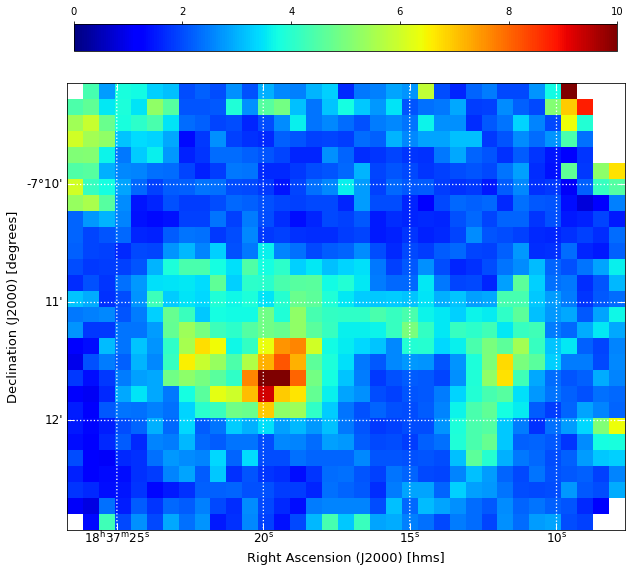

In [127]:
plots = plotter(path1)
plots.map_plot(CODep, vmin=0, vmax=10) #CHECK CUZ THIS LOOKS TOO HIGH...MIGHT HAVE TO DO WITH RMS MAP


vmin 0
vmax 1


(<Figure size 720x720 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Right Ascension (J2000) [hms]', ylabel='Declination (J2000) [degrees]'>)

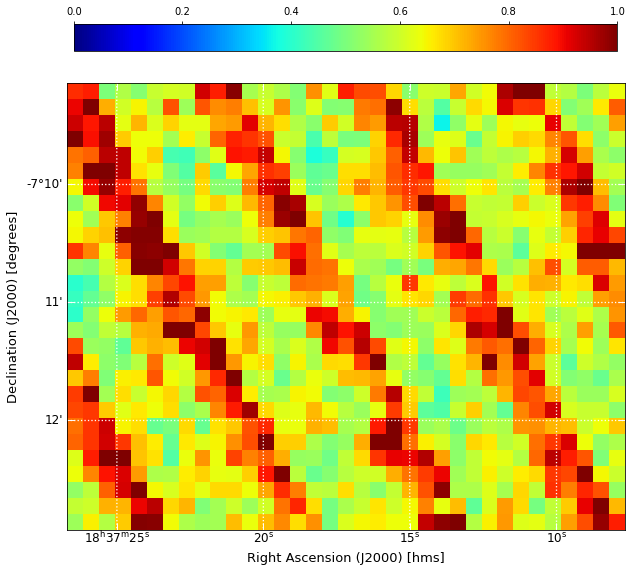

In [49]:
plots.map_plot(RMS1, vmin=0, vmax=1)

vmin 5
vmax 10


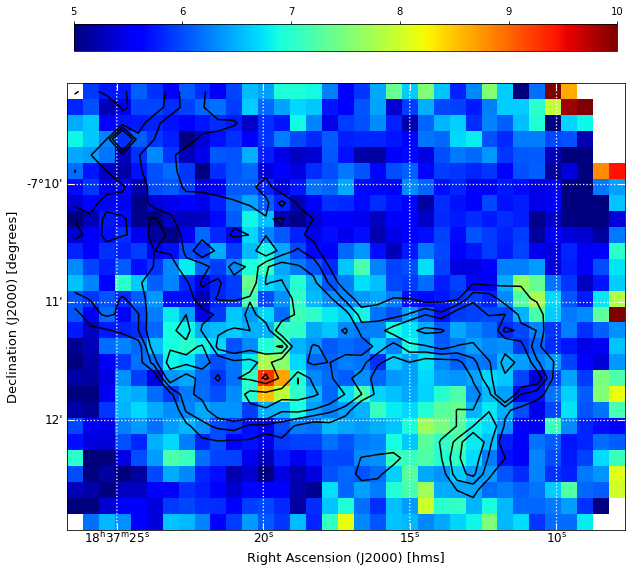

In [129]:
cont = '/Users/caitlingainey/Desktop/CASSUM2021/CloudO/CloudO_8nu2.fits'

levels=(60,70,80,100, 110, 120)
fig, ax = plots.map_plot(Tex2, contour_path=cont, cont_levels=levels, vmin=5, vmax=10)

SpectralCube with shape=(307, 28, 35) and unit=K:
 n_x:     35  type_x: RA---SFL  unit_x: deg    range:   279.283069 deg:  279.360192 deg
 n_y:     28  type_y: DEC--SFL  unit_y: deg    range:    -7.214355 deg:   -7.153603 deg
 n_s:    307  type_s: VRAD      unit_s: km / s  range:      -48.975 km / s:     149.925 km / s


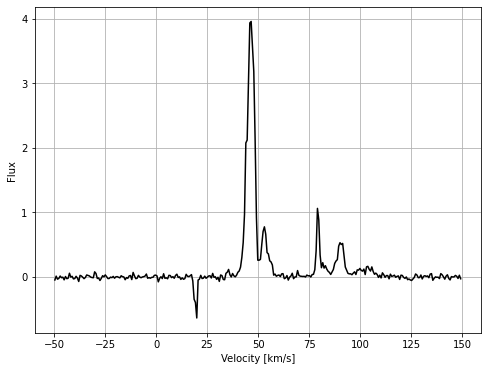

In [101]:
path2 = '/Users/caitlingainey/Desktop/CASSUM2021/CloudO/CloudO_IRAM_13CO21_crop.fits'
plots = plotter(path2)

cube = fits.open(path2)
cube = SpectralCube.read(cube)
cube = cube.with_spectral_unit(u.km / u.s) 

fig, ax = plots.spectrum()

In [7]:
class plotter():
    def __init__(self, cube_path):
        '''
        Initializes the class and inputs the 3D cube header that you wish to plot
        
        Parameters
        ----------
        cube_path: string
            the path to your 3D cube of data
        
        '''
        cube = fits.open(cube_path)
        cube = SpectralCube.read(cube)
        self.cube = cube.with_spectral_unit(u.km / u.s)
        header = self.cube.header
        header1 = self.cube[0].header
        self.wcs_cube = WCS(header1)
        print(self.cube)
        
    def spectrum(self):
        '''
        Plots the spectrum of your cube
        
        Returns
        -------
        fig, ax: matplotlib subplot
            the fig, ax for your spectrum plot
        
        '''
        Vsh, Ysh, Xsh = self.cube.shape
        chans = np.linspace(0,Vsh,num=Vsh)
        velo = np.zeros(Vsh)
        for i in range(0,Vsh):
            velo[i]= (self.cube.header['CRVAL3']) + ((i-self.cube.header['CRPIX3'])*self.cube.header['CDELT3'])
        spec=0.
        pix =0
        for xx in range(0,Xsh):
            for yy in range(0,Ysh):
                if np.all(np.isnan(self.cube[:,yy,xx]))==False:
                    spec = spec + self.cube[:,yy,xx]
                    pix = pix+1
                    
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(velo, spec/pix, color='black')
        ax.grid()
        ax.set_xlabel('Velocity [km/s]')
        ax.set_ylabel('Flux')
        
        #return chans, velo, spec/pix
        return fig, ax
    
    def map_plot(self, data, contour_path=None, cont_levels=None, figsize=(10,10), cmap='jet', scale=0.8, colorbar=True, 
           grid=True, clabel=None, fraction=0.05, location='top', **kwargs):
        '''
        This can plot any of the 2D maps produced in the Mapper class
        
        Parameters
        ----------
        data: array-like
            the data you wish to plot
        contour_path: string (optional)
            the path to the contours you wish to overlay on your plot
        cont_levels: tuple (optional)
            the list of levels on your contour plot
        figsize: tuple (optional)
            the size of the figure
        cmap: string (optional)
            the colormap for the figure
        scale: float (optional)
            the scale of the figure, between 0 and 1
        colorbar: Boolean (optional)
            if True, a colorbar will appear with the figure
        grid: Boolean (optional)
            if True, a grid will appear on the figure
        clabel: string (optional)
            the label for the colorbar
        fraction: float (optional)
            the fraction of the figure the colorbar takes up
        location: string (optional)
            the location of the colorbar
        
        Retruns
        -------
        fig, ax: matplotlib attributes
            the fig, ax for the plot you created
        
        '''
        fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection':self.wcs_cube})
        ax.set_xlabel('Right Ascension (J2000) [hms]', fontsize=13)
        ax.set_ylabel('Declination (J2000) [degrees]', fontsize=13)

        med = np.nanmedian(data)
        sigma = np.nanstd(data)
        low = med - scale*sigma
        high = med + scale*sigma
    
        for key, value in kwargs.items():
            print(key, value)
        if not kwargs:
            im = ax.imshow(data, origin='lower', cmap=cmap, vmin=low, vmax=high)
        else:
            im = ax.imshow(data, origin='lower', cmap=cmap, **kwargs)
        if colorbar == True:
            plt.colorbar(im, pad=0.06, fraction=fraction, location=location,label=clabel)
            
        ax.tick_params(direction='in', length=7, labelsize=12, color='white')
    
        if grid == True:
            ax.coords.grid(color='white', ls='dotted', linewidth=1.3)
        
        if contour_path != None:
            contours = fits.open(contour_path)
            contour = contours[0].data
            wcs_contour = WCS(contours[0].header)
            plt.contour(contour, transform=ax.get_transform(wcs_contour), levels=cont_levels, colors='black', alpha=1.0)

        return fig, ax



vmin 0.04
vmax 0.15


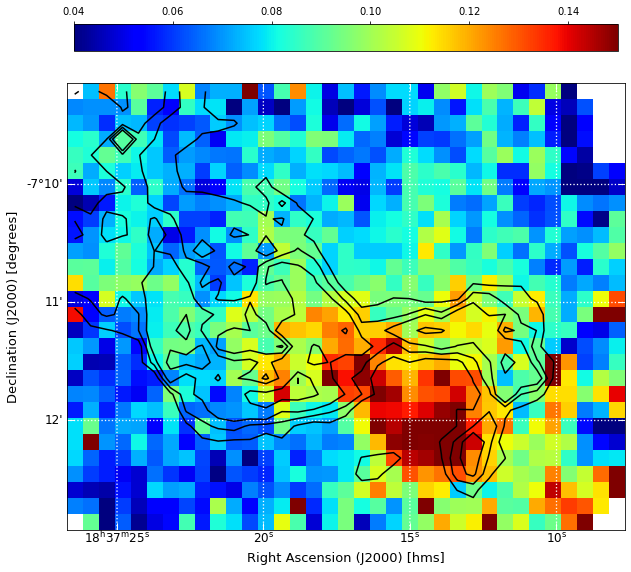

In [193]:
cont = '/Users/caitlingainey/Desktop/CASSUM2021/CloudO/CloudO_8nu2.fits'

plots = plotter(path1)
levels=(60,70,80,100, 110, 120)
fig, ax = plots.map_plot(sig, contour_path=cont, cont_levels=levels, vmin=.04, vmax=.15)

SpectralCube with shape=(307, 28, 35) and unit=K:
 n_x:     35  type_x: RA---SFL  unit_x: deg    range:   279.283069 deg:  279.360192 deg
 n_y:     28  type_y: DEC--SFL  unit_y: deg    range:    -7.214355 deg:   -7.153603 deg
 n_s:    307  type_s: VRAD      unit_s: km / s  range:      -48.975 km / s:     149.925 km / s
vmin 10
vmax 50


(<Figure size 720x720 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Right Ascension (J2000) [hms]', ylabel='Declination (J2000) [degrees]'>)

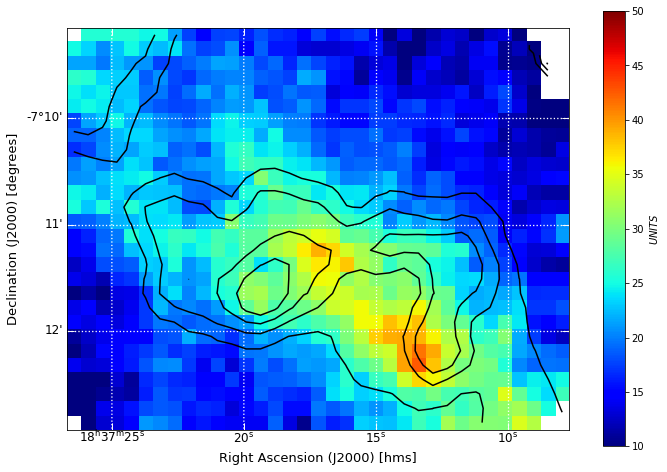

In [11]:
Hersch_sig = '/Users/caitlingainey/Desktop/CASSUM2021/CloudO/CloudO_regridWanggiSigma.fits'
levels = (0.1, 0.15, 0.2, 0.25)

path1 = '/Users/caitlingainey/Desktop/CASSUM2021/CloudO/CloudO_FUGIN_13CO10_crop.fits'
data_path = '/Users/caitlingainey/Desktop/CASSUM2021/IntegratedInt/CloudO_13CO21_moment_0.fits'
sig = fits.open(data_path)

plots = plotter(path1)
plots.map_plot(sig[0].data, contour_path=Hersch_sig, cont_levels=levels, vmin=10, vmax=50,location='right', clabel=r'$UNITS$', fraction=0.039)



SpectralCube with shape=(307, 25, 32) and unit=K:
 n_x:     32  type_x: RA---SFL  unit_x: deg    range:   279.521101 deg:  279.591425 deg
 n_y:     25  type_y: DEC--SFL  unit_y: deg    range:    -7.074849 deg:   -7.020846 deg
 n_s:    307  type_s: VRAD      unit_s: km / s  range:      -48.975 km / s:     149.925 km / s
vmin 10
vmax 50


(<Figure size 720x720 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Right Ascension (J2000) [hms]', ylabel='Declination (J2000) [degrees]'>)

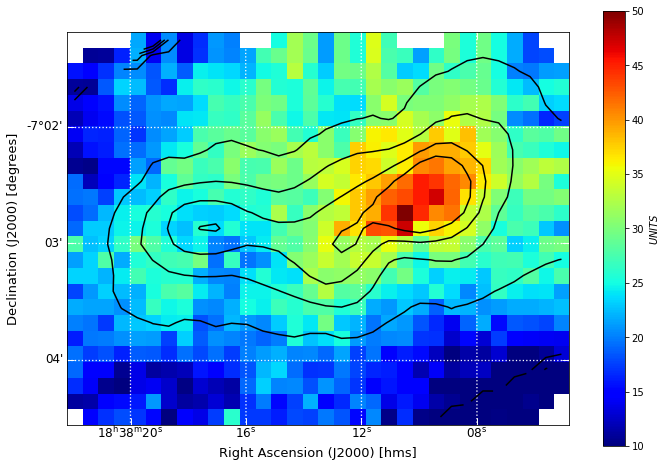

In [13]:
Hersch_sig = '/Users/caitlingainey/Desktop/CASSUM2021/CloudY/CloudY_regridWanggiSigma.fits'
levels = (0.1, 0.2, 0.3, 0.4)

path1 = '/Users/caitlingainey/Desktop/CASSUM2021/CloudY/CloudY_FUGIN_13CO10_crop_eq_trim.fits'
data_path = '/Users/caitlingainey/Desktop/CASSUM2021/IntegratedInt/CloudY_13CO21_moment_0.fits'
sig = fits.open(data_path)

plots = plotter(path1)
plots.map_plot(sig[0].data, contour_path=Hersch_sig, cont_levels=levels, vmin=10, vmax=50,location='right', clabel=r'$UNITS$', fraction=0.039)


SpectralCube with shape=(307, 43, 17) and unit=K:
 n_x:     17  type_x: RA---SFL  unit_x: deg    range:   278.565219 deg:  278.601719 deg
 n_y:     43  type_y: DEC--SFL  unit_y: deg    range:    -8.564298 deg:   -8.469725 deg
 n_s:    307  type_s: VRAD      unit_s: km / s  range:      -48.975 km / s:     149.925 km / s
vmin 0
vmax 30


(<Figure size 720x720 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Right Ascension (J2000) [hms]', ylabel='Declination (J2000) [degrees]'>)

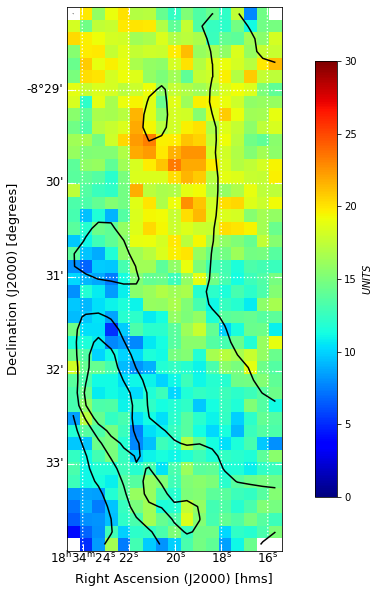

In [8]:
Hersch_sig = '/Users/caitlingainey/Desktop/CASSUM2021/CloudW/CloudW_regridWanggiSigma.fits'
levels = (0.05, 0.1, 0.15, 0.2, 0.25)

path1 = '/Users/caitlingainey/Desktop/CASSUM2021/CloudW/CloudW_FUGIN_13CO10_crop_eq_trim.fits'
data_path = '/Users/caitlingainey/Desktop/CASSUM2021/CloudW/CloudW_50to70_13CO21_moment_0.fits'
sig = fits.open(data_path)

plots = plotter(path1)
plots.map_plot(sig[0].data, contour_path=Hersch_sig, cont_levels=levels, vmin=0, vmax=30,location='right', clabel=r'$UNITS$', fraction=0.039)

In [129]:
path1 = '/Users/caitlingainey/Desktop/CASSUM2021/CloudY/CloudY_FUGIN_13CO10_crop_eq_trim.fits'
data_path = '/Users/caitlingainey/Desktop/CASSUM2021/Y_glimpse.fits'
sig = fits.open(data_path)

sig = sig[0].data[:,:,:]
print(sig[0].shape)

#plots = plotter(path1)
#plots.map_plot(sig[0].data, vmin=80, vmax=180,location='right', clabel=r'$UNITS$', fraction=0.039)



(228, 351)


(555, 487)
vmin 150
vmax 250


(<Figure size 720x720 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Right Ascension (J2000) [hms]', ylabel='Declination (J2000) [degrees]'>)

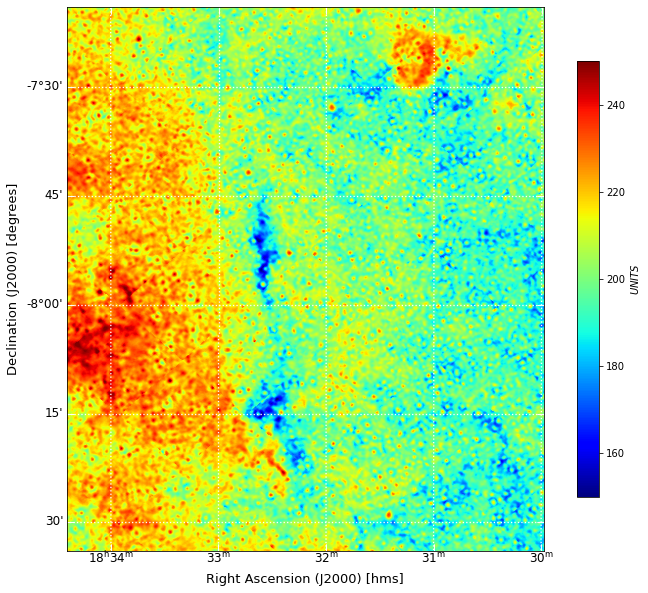

In [67]:
path1 = '/Users/caitlingainey/Desktop/CASSUM2021/CloudW/CloudW_FUGIN_13CO10_crop_eq_trim.fits'
data_path = '/Users/caitlingainey/Desktop/CASSUM2021/W_glimpse.fits'
sig = fits.open(data_path)

sig = sig[0].data[:,:,:]
print(sig[0].shape)

plots = plotter(path1)
plots.map_plot(sig[0].data, vmin=150, vmax=250,location='right', clabel=r'$UNITS$', fraction=0.039)



(398, 469)
vmin 90
vmax 200


(<Figure size 720x720 with 2 Axes>,
 <WCSAxesSubplot:xlabel='Right Ascension (J2000) [hms]', ylabel='Declination (J2000) [degrees]'>)

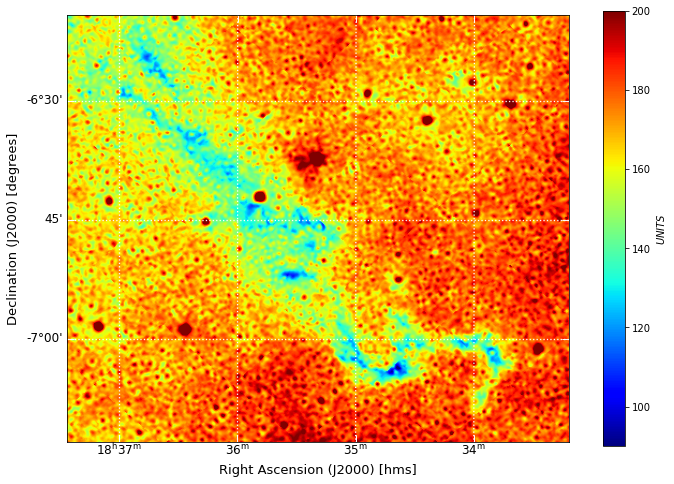

In [70]:
path1 = '/Users/caitlingainey/Desktop/CASSUM2021/CloudO/CloudO_FUGIN_13CO10_crop.fits'
data_path = '/Users/caitlingainey/Desktop/CASSUM2021/O_glimpse.fits'
sig = fits.open(data_path)

sig = sig[0].data[:,:,:]
print(sig[0].shape)

plots = plotter(path1)
plots.map_plot(sig[0].data, vmin=90, vmax=200,location='right', clabel=r'$UNITS$', fraction=0.039)


